# Imports and loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from loads import *

PATH_FOLDER = "MovieSummaries/"

In [2]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

## CLEANING

#### MOVIE METADATA Cleaning

We are first extracting variables that have the form (ID : variable) tuples to be able to use these features.

In [3]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

A lot of columns in the dataframe contain IDs that we don't need, we are thus, dropping them.

In [4]:
# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

Our main interest is to see what features result in higher boxe office revenues, so we need to drop movies with missing revenue (Nan).

In [5]:
# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie box office revenue'], inplace=True)

One of our feature of interest is the release date of the movies. We are thus, processing the column for it to be usable in our analysis. We extract Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together).

In [6]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie release date"], inplace=True)
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie release date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie release date'],errors='coerce').dt.month

### Inflation

To be able to compare the the relative boxe office revenues across different years, we need to take inflation into account.

In [7]:
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
movie_with_inflation = pd.merge(movie_df, inflation.drop(['Annual'], axis=1), on='Year')
movie_with_inflation['Revenue with inflation'] = movie_with_inflation['Movie box office revenue'] * movie_with_inflation['Cumulative Inflation to 2022']

The original distribution of the inflated movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation on the x-axis, we approximate a "more" normal distribution, making the data more amenable to statistical analyses that assume normality.

Text(0, 0.5, 'Number of movies')

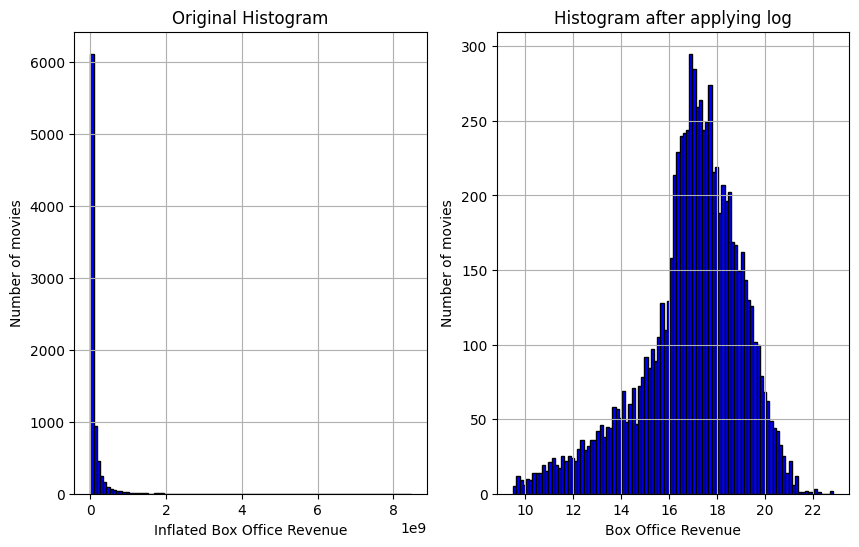

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
movie_with_inflation['Revenue with inflation'].hist(ax=axs[0], bins=100, color='blue', edgecolor='black')
movie_with_inflation['log_revenues'] = np.log(movie_with_inflation['Revenue with inflation'])
movie_with_inflation['log_revenues'].hist(ax=axs[1], bins=100, color='blue', edgecolor='black')
axs[0].set_title('Original Histogram')
axs[0].set_xlabel('Inflated Box Office Revenue')
axs[0].set_ylabel('Number of movies')
axs[1].set_title('Histogram after applying log')
axs[1].set_xlabel('Box Office Revenue')
axs[1].set_ylabel('Number of movies')

#### CHARACTER METADATA Cleaning

Again, a lot of columns in the dataframe contain IDs that we don't need, as well as actors' heights, we are thus, dropping them.

In [9]:
# Dropping unnecessary character-related columns from the DataFrame
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

## Splitting

We are now splitting the dataframes into many small different dataframes for each feature. Each small df has one feature and 'log_revenues'. These small dataframes are created for the analysis to be easier.

In [10]:
# Extracting 'Movie runtime' and 'log_revenues' columns into a new dataframe
movie_runtime_df = movie_with_inflation[['Movie runtime', 'log_revenues']].copy()
# Extracting 'Movie Languages' and 'log_revenues' columns into a new dataframe
movie_languages_df = movie_with_inflation[['Movie Languages', 'log_revenues']].copy()
# Extracting 'Movie Countries' and 'log_revenues' columns into a new dataframe
movie_countries_df = movie_with_inflation[['Movie Countries', 'log_revenues']].copy()
# Extracting 'Movie Genres' and 'log_revenues' columns into a new dataframe
movie_genres_df = movie_with_inflation[['Movie Genres', 'log_revenues']].copy()
# Extracting 'Month' and 'log_revenues' columns into a new dataframe
months_df = movie_with_inflation[['Month', 'log_revenues']].copy()
# Extracting 'Year' and 'log_revenues' columns into a new dataframe
years_df = movie_with_inflation[['Year', 'log_revenues']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature

In [11]:
# Drop NaNs in each small dataframes
movie_runtime_df.dropna(subset=['Movie runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie Genres'], inplace=True)
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

We then need to merge character and movie dataframes, to be able to extract information on actors and their impact on boxe office revenues

In [12]:
# Merging character_df and movie_with_inflation DataFrames on 'Wikipedia movie ID'
# Dropping the 'Movie release date' column from character_df to avoid duplicate columns after the merge
character_movie_merged_df = pd.merge(character_df.drop(['Movie release date'],axis=1), movie_with_inflation, on=['Wikipedia movie ID'])


In [13]:
actor_gender_movie_df = character_movie_merged_df[['Movie name','log_revenues','Actor name','Actor gender']].copy()

In [14]:
actor_gender_movie_df.dropna(inplace=True)

In [30]:
actor_gender_movie_df['Percentage Women'] = (actor_gender_movie_df.groupby('Movie name')['Actor gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of float type
                                             )


In [31]:
actor_gender_movie_df.head(20)

,Movie name,log_revenues,Actor name,Actor gender,Percentage Women
0,Ghosts of Mars,16.957621,Wanda De Jesus,F,35
1,Ghosts of Mars,16.957621,Natasha Henstridge,F,35
2,Ghosts of Mars,16.957621,Ice Cube,M,35
3,Ghosts of Mars,16.957621,Jason Statham,M,35
4,Ghosts of Mars,16.957621,Clea DuVall,F,35
5,Ghosts of Mars,16.957621,Pam Grier,F,35
6,Ghosts of Mars,16.957621,Joanna Cassidy,F,35
7,Ghosts of Mars,16.957621,Richard Cetrone,M,35
8,Ghosts of Mars,16.957621,Liam Waite,M,35
9,Ghosts of Mars,16.957621,Duane Davis,M,35


In [32]:
# Creating a DataFrame with actor gender, actor name, and log_revenues from the merged DataFrame
actor_gender_df = actor_gender_movie_df[['Percentage Women','Actor name','log_revenues']].copy()
# Removing duplicate rows from actor_gender_df based on all columns
actor_gender_df.drop_duplicates()
# Creating a new DataFrame with actor gender and log_revenues, dropping rows with missing actor gender
gender_df = actor_gender_df[['Percentage Women','log_revenues']].copy()
gender_df.dropna(subset=['Percentage Women'], inplace=True)

In [18]:
# Creating a DataFrame with actor name, actor age at movie release, and log_revenues from the merged DataFrame
actor_df = character_movie_merged_df[['Actor name','Actor age at movie release','log_revenues']].copy()
actor_df.dropna()

,Actor name,Actor age at movie release,log_revenues
0,Wanda De Jesus,42.0,16.957621
1,Natasha Henstridge,27.0,16.957621
2,Ice Cube,32.0,16.957621
3,Jason Statham,33.0,16.957621
4,Clea DuVall,23.0,16.957621
...,...,...,...
100848,Roland Culver,64.0,17.746917
100849,Michael Hordern,53.0,17.746917
100850,Reginald Beckwith,56.0,17.746917
100851,Gong Yoo,32.0,17.503715


## Quantization

In this section we transform runtimes, female percentages and years into categories to be able to run a regression analysis with categorical features

In [19]:
# Calculate the minimum and maximum years in the 'Year' column
min_year = years_df['Year'].min()
max_year = years_df['Year'].max()

# Create intervals of 10 years and assign labels based on the minimum and maximum years
years_df['year_intervals'] = pd.cut(years_df['Year'], 
                                    bins=range(min_year, max_year + 11, 10),  # Define bins for 10-year intervals
                                    labels=[f"{start}-{start + 9}" for start in range(min_year, max_year, 10)],  # Create labels for intervals
                                    include_lowest=True)  # Include the lowest value in the interval

# The 'year_intervals' column now contains the corresponding interval for each year

In [20]:
# Cast 'Movie runtime' to integers
movie_runtime_df['Movie runtime'] = movie_runtime_df['Movie runtime'].astype(int)

# Calculate the minimum and maximum runtimes in the 'Movie runtime' column
min_runtime = movie_runtime_df['Movie runtime'].min()
max_runtime = movie_runtime_df['Movie runtime'].max()

# Create intervals of 30 for runtimes until 220, and a separate interval for values greater than 220 but smaller than the maximum runtime
runtime_bins = [i for i in range(min_runtime, min(max_runtime, 221), 30)] + [float('inf')]

# Create labels for the runtime intervals
runtime_labels = [f"{start}-{start + 29}" if start + 29 < min(max_runtime, 220) else f"{min(max_runtime, 220)+1}-{max_runtime}" for start in range(min_runtime, min(max_runtime, 221), 30)]

# Assign the intervals to the 'Movie runtime' column
movie_runtime_df['runtime_intervals'] = pd.cut(movie_runtime_df['Movie runtime'],
                                       bins=runtime_bins,
                                       labels=runtime_labels,
                                       include_lowest=True)

# The 'runtime_intervals' column now contains the corresponding interval for each runtime

In [21]:
movie_runtime_df.head()

,Movie runtime,log_revenues,runtime_intervals
0,98,16.957621,70-99
1,123,17.698161,100-129
2,103,15.838345,100-129
3,87,18.583094,70-99
4,113,19.267046,100-129


In [37]:
# Create intervals of size 10 for the 'Percentage Women' column
gender_df['Percentage Women Intervals'] = pd.cut(gender_df['Percentage Women'],
                                                             bins=range(0, 101, 10),
                                                             labels=[f"{start}-{start + 9}" for start in range(0, 100, 10)],
                                                             include_lowest=True)

In [38]:
gender_df.sample(10)

,Percentage Women,log_revenues,Percentage Women Intervals
80833,15,20.724992,10-19
70396,31,18.295872,30-39
7299,45,18.408847,40-49
42687,30,17.416025,20-29
56729,25,14.969762,20-29
50781,14,21.278136,10-19
100096,35,20.329674,30-39
3104,20,20.963738,10-19
53713,36,20.020816,30-39
10217,47,16.997805,40-49
